In [5]:
# same as subm006
#+ tta (horizontal flip only)
# horizontal flip helps (havent figured out a way to shift/zoom yet)

import os
import tensorflow as tf
os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
np.random.seed(1)
tf.set_random_seed(1)



import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout2D, Activation
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
        
PATH = 'input'

sample_df = pd.read_csv('input/sample_submission.csv')
test_ids = sample_df.id.values

Using TensorFlow backend.


In [6]:
from sklearn.model_selection import KFold

FOLDS_CSV = os.path.join(PATH, 'folds.csv')
def generate_folds():
    n_fold = 5
    depths = pd.read_csv(os.path.join(PATH, 'depths.csv'))
    depths.sort_values('z', inplace=True)
    depths.drop('z', axis=1, inplace=True)
    depths['fold'] = (list(range(n_fold))*depths.shape[0])[:depths.shape[0]]
    print(depths.head())
    depths.to_csv(FOLDS_CSV, index=False)

if not os.path.exists(FOLDS_CSV):
    generate_folds()


In [7]:
im_width = 128
im_height = 128
im_chan = 1

In [8]:
X_train = np.load('input/X_train_128.npy')
y_train = np.load('input/y_train_128.npy')
X_test = np.load('input/X_test_128.npy')

In [9]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def get_border_mask(pool_size, y_true):
    negative = 1 - y_true
    positive = y_true
    positive = K.pool2d(positive, pool_size=pool_size, padding="same")
    negative = K.pool2d(negative, pool_size=pool_size, padding="same")
    border = positive * negative
    return border

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def dice_coef_border(y_true, y_pred):
    border = get_border_mask((21, 21), y_true)

    border = K.flatten(border)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.tf.gather(y_true_f, K.tf.where(border > 0.5))
    y_pred_f = K.tf.gather(y_pred_f, K.tf.where(border > 0.5))

    return dice_coef(y_true_f, y_pred_f)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def bce_border(y_true, y_pred):
    border = get_border_mask((16, 16), y_true)

    border = K.flatten(border)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.tf.gather(y_true_f, K.tf.where(border > 0.5))
    y_pred_f = K.tf.gather(y_pred_f, K.tf.where(border > 0.5))

    return K.binary_crossentropy(y_true_f, y_pred_f)

def custom2(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1) * 0.5 + dice_coef_loss(y_true, y_pred) * 0.5


def double_conv_layer(x, size, dropout=0.0, batch_norm=True):
    if K.image_dim_ordering() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv

def build_unet2(dropout_val=0.1, weights=None):
    if K.image_dim_ordering() == 'th':
        inputs = Input((im_height, im_width, im_chan), name='inputs1')
        axis = 1
    else:
        inputs = Input((im_height, im_width, im_chan), name='inputs1')
        axis = 3

    filters = 16
    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters, dropout_val)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    output_mask_channels = 1
    conv_final = Conv2D(output_mask_channels, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)    

    model = Model(inputs=[inputs], outputs=[conv_final])
    model.compile(optimizer='adam', loss=custom2)
    return model


In [10]:
def load_fold(X_train, y_train, fold):
    train_df = pd.read_csv(os.path.join(PATH, 'train.csv'))
    train_ids = train_df.id.values
    
    folds = pd.read_csv(FOLDS_CSV)
    fold_dict = folds.set_index('id').to_dict()['fold']
    
    fold_train = [fold_dict[x]!=fold for x in train_ids]
    fold_val = [fold_dict[x]==fold for x in train_ids]
    
    X_fold, y_fold = X_train[fold_train], y_train[fold_train]    
    X_val, y_val = X_train[fold_val], y_train[fold_val]    
    return X_fold, y_fold, X_val, y_val



In [17]:
def run_fold(X_fold, y_fold, X_val, y_val, weights_file):
    model = build_unet2()
        
    callbacks = [
        EarlyStopping(patience=20, verbose=1),
        ReduceLROnPlateau(patience=5, verbose=1),
        ModelCheckpoint(weights_file, verbose=1, save_best_only=True)
    ]
        
    data_gen_args = dict(
        width_shift_range=0.25,
        height_shift_range=0.25,
        fill_mode='reflect',
        horizontal_flip=True,
        zoom_range=0.1
    )
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    
    seed = 1
    image_datagen.fit(X_fold, augment=True, seed=seed)
    mask_datagen.fit(y_fold, augment=True, seed=seed)

    image_generator = image_datagen.flow(X_fold, batch_size=32, seed=seed)
    mask_generator = mask_datagen.flow(y_fold, batch_size=32, seed=seed)    
    train_generator = zip(image_generator, mask_generator)

    results = model.fit_generator(
        train_generator, 
        epochs=100, 
        steps_per_epoch=len(X_fold)//32,
        callbacks=callbacks,
        validation_data=(X_val, y_val))

    return model

In [18]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)


running fold  2
Epoch 1/100
99/99 [==============================] - 20s 199ms/step - loss: 0.4212 - val_loss: 0.4950

Epoch 00001: val_loss improved from inf to 0.49497, saving model to model-tgs-salt-fold2.h5
Epoch 2/100
99/99 [==============================] - 9s 89ms/step - loss: 0.3327 - val_loss: 0.5000

Epoch 00002: val_loss did not improve
Epoch 3/100
99/99 [==============================] - 9s 86ms/step - loss: 0.3257 - val_loss: 0.4233

Epoch 00003: val_loss improved from 0.49497 to 0.42327, saving model to model-tgs-salt-fold2.h5
Epoch 4/100
99/99 [==============================] - 9s 87ms/step - loss: 0.3095 - val_loss: 0.2800

Epoch 00004: val_loss improved from 0.42327 to 0.28005, saving model to model-tgs-salt-fold2.h5
Epoch 5/100
99/99 [==============================] - 9s 87ms/step - loss: 0.2911 - val_loss: 0.3055

Epoch 00005: val_loss did not improve
Epoch 6/100
99/99 [==============================] - 9s 88ms/step - loss: 0.2838 - val_loss: 0.3570

Epoch 00006: val

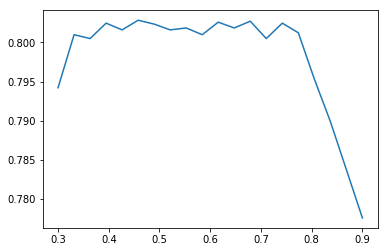

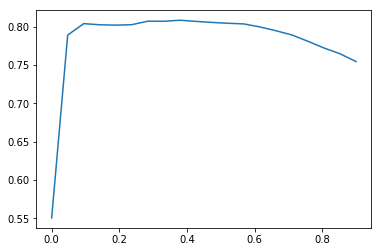

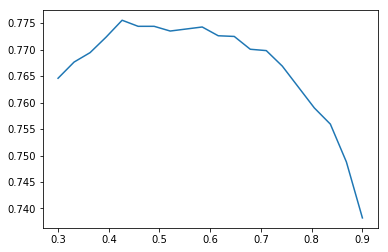

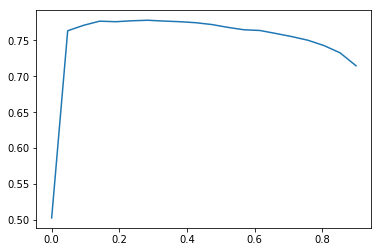

In [21]:
for fold in []: # range(4, 5):
    print('running fold ', fold)
    X_fold, y_fold, X_val, y_val = load_fold(X_train, y_train, fold)
    weights_file = f"model-tgs-salt-fold{fold}.h5"    
    
    run_fold(X_fold, y_fold, X_val, y_val, weights_file)
    
    model = build_unet2()
    model.load_weights(weights_file)
    val_loss = model.evaluate(X_val, y_val, verbose=1)
    print('val loss: ', val_loss)
    
    # predict eval ds with tta
    val_preds1 = model.predict(X_val, verbose=1)
    val_preds3 = model.predict(X_val[:, :, ::-1, :], verbose=1) # hflip
    val_preds = val_preds1 * val_preds3[:, :, ::-1]
    
    # predict test ds with tta
    test_preds1 = model.predict(X_test, verbose=1)
    test_preds3 = model.predict(X_test[:, :, ::-1, :], verbose=1) # hflip
    test_preds = test_preds1 * test_preds3[:, :, ::-1]    

    # find best threshold for non-tta
    thres = np.linspace(0.3, 0.9, 20)
    thres_ioc = [iou_metric_batch(y_val, np.int32(val_preds1 > t)) for t in thres]
    best_thres = thres[np.argmax(thres_ioc)]
    print('without tta :', best_thres, max(thres_ioc))

    plt.figure()
    plt.plot(thres, thres_ioc);
    
    # find best threshold for tta
    thres = np.linspace(0.0, 0.9, 20)
    thres_ioc = [iou_metric_batch(y_val, np.int32(val_preds > t)) for t in thres]
    best_thres_tta = thres[np.argmax(thres_ioc)]
    print('with tta: ', best_thres_tta, max(thres_ioc))
    
    plt.figure()
    plt.plot(thres, thres_ioc);
    
    np.save(f"preds_fold{fold}", test_preds > best_thres_tta)
    np.save(f"val_preds_fold{fold}", val_preds > best_thres_tta)

In [24]:
preds = np.zeros_like(X_test)
for fold in range(5):
    p = np.load('preds_fold%s.npy' % fold)
    preds += p
preds /= 5

In [25]:
preds_ = []
for i in tqdm(range(len(preds))):
    preds_.append(resize(np.squeeze(preds[i]), (101, 101), mode='constant', preserve_range=True))

  0%|          | 0/18000 [00:00<?, ?it/s]/opt/miniconda2/envs/avito/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 18000/18000 [00:15<00:00, 1173.36it/s]


In [26]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 

In [27]:

rows = []
for image_id, p in zip(test_ids, preds_):
    rows.append([image_id, rle_encode(np.round(p).T)])
    
sub = pd.DataFrame(rows, columns=['id', 'rle_mask'])
sub.to_csv('submissions/subm_013.csv', index=False)

evaluating fold  0
810/810 [==============================] - 5s 7ms/step
val loss:  0.13396431697003636
810/810 [==============================] - 1s 1ms/step
without tta : 0.6473684210526316 0.7848148148148149
with tta:  0.14210526315789473 0.7860493827160494
evaluating fold  1
804/804 [==============================] - 5s 7ms/step
val loss:  0.13235422748312428
804/804 [==============================] - 1s 1ms/step
without tta : 0.7105263157894738 0.7827114427860696
with tta:  0.28421052631578947 0.7896766169154229
evaluating fold  2
811/811 [==============================] - 6s 7ms/step
val loss:  0.14500804613866877
811/811 [==============================] - 1s 1ms/step
without tta : 0.4578947368421053 0.8028360049321825
with tta:  0.37894736842105264 0.8086313193588163
evaluating fold  3
790/790 [==============================] - 6s 7ms/step
val loss:  0.13725923001766205
790/790 [==============================] - 1s 1ms/step
without tta : 0.7105263157894738 0.7362025316455697
wi

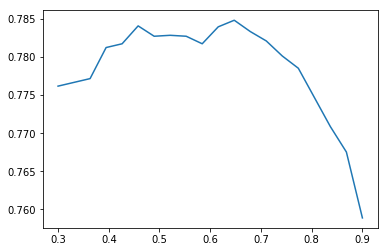

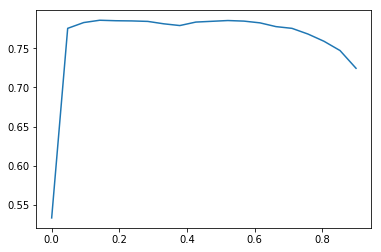

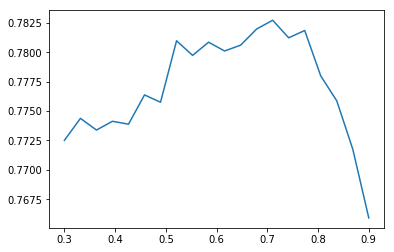

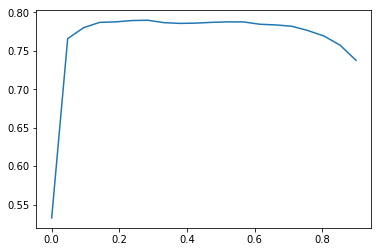

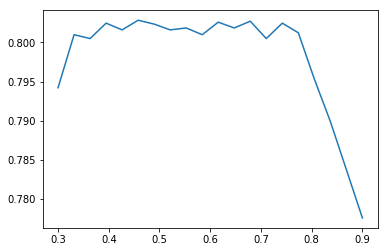

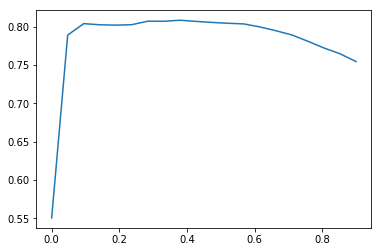

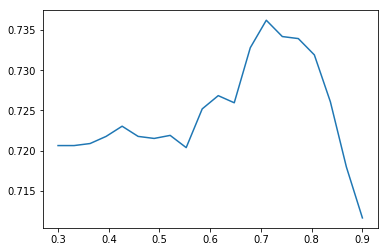

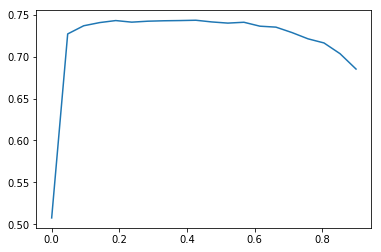

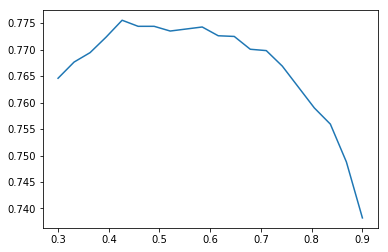

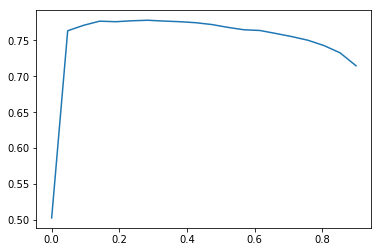

In [23]:
# evaluate from saved checkpoints
for fold in range(5):
    print('evaluating fold ', fold)
    X_fold, y_fold, X_val, y_val = load_fold(X_train, y_train, fold)
    weights_file = f"model-tgs-salt-fold{fold}.h5"    
    
    model = build_unet2()
    model.load_weights(weights_file)
    val_loss = model.evaluate(X_val, y_val, verbose=1)
    print('val loss: ', val_loss)
    
    # predict eval ds with tta
    val_preds1 = model.predict(X_val, verbose=1)
    val_preds3 = model.predict(X_val[:, :, ::-1, :], verbose=1) # hflip
    val_preds = val_preds1 * val_preds3[:, :, ::-1]

    # find best threshold for non-tta
    thres = np.linspace(0.3, 0.9, 20)
    thres_ioc = [iou_metric_batch(y_val, np.int32(val_preds1 > t)) for t in thres]
    best_thres = thres[np.argmax(thres_ioc)]
    print('without tta :', best_thres, max(thres_ioc))

    plt.figure()
    plt.plot(thres, thres_ioc);

    # find best threshold for tta
    thres = np.linspace(0.0, 0.9, 20)
    thres_ioc = [iou_metric_batch(y_val, np.int32(val_preds > t)) for t in thres]
    best_thres_tta = thres[np.argmax(thres_ioc)]
    print('with tta: ', best_thres_tta, max(thres_ioc))

    plt.figure()
    plt.plot(thres, thres_ioc);


In [ ]:
"""
evaluating fold  0
val loss:  0.13396431697003636
without tta : 0.6473684210526316 0.7848148148148149
with tta:  0.14210526315789473 0.7860493827160494

evaluating fold  1
val loss:  0.13235422748312428
without tta : 0.7105263157894738 0.7827114427860696
with tta:  0.28421052631578947 0.7896766169154229

evaluating fold  2
val loss:  0.14500804613866877
without tta : 0.4578947368421053 0.8028360049321825
with tta:  0.37894736842105264 0.8086313193588163

evaluating fold  3
val loss:  0.13725923001766205
without tta : 0.7105263157894738 0.7362025316455697
with tta:  0.4263157894736842 0.7434177215189873

evaluating fold  4
val loss:  0.14418715124676942
without tta : 0.4263157894736842 0.7755414012738853
with tta:  0.28421052631578947 0.7782165605095541


"""